<center><h1>Character embeddings for text classification</h1></center>

character level embedding can be very helpful as it tends to solve the typos issues and out of vocabulary words.

<center><img src="https://www.researchgate.net/profile/Hoang_Pham26/publication/316875275/figure/fig1/AS:493031154556929@1494559195862/The-CNN-for-extracting-character-level-features-of-word-Hoc-sinh-Student.png"></center>

In [45]:
import spacy
import pandas as pd
import numpy as np

# nlp = spacy.load("en_core_web_md")
dataset = pd.read_csv("chatbot-data.tsv", sep="\t")
dataset.head()

,Unnamed: 0,text,intent
0,0,hello there,greetings
1,1,good morning,greetings
2,2,welcome,greetings
3,3,"hi!, how are you",greetings
4,4,Hi there !!,greetings


In [46]:
def get_longest_sequence(texts):
    longest_input = 0
    for text in texts:
        text_len= len(text)
        longest_input = max(longest_input, text_len)
    return longest_input

In [47]:
longest_seq = get_longest_sequence(dataset['text'])
longest_seq

57

In [48]:
from collections import defaultdict
import string

# let's see how many unique characters we have!
unique_chars = len(string.ascii_letters+string.digits)
unique_chars

62

There are some special characters

In [49]:
char2idx = defaultdict(lambda:0)

for idx, char in enumerate(string.ascii_letters+string.digits, 1):
    char2idx[char] = idx

In [50]:
char2idx['س']

0

In [51]:
char2idx['a']

1

Now prepare your data

In [52]:
def encode_text(text):
    text_v = np.zeros((longest_seq, unique_chars))
    for i, char in enumerate(text):
        if i<longest_seq:
            text_v[i, char2idx[char]] = 1
    return text_v

In [53]:
encode_text("abcd")

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [54]:
def encode_texts(texts):
    text_v = np.zeros((len(texts), longest_seq, unique_chars))
    for i, text in enumerate(texts):
        text_v[i] = encode_text(text)
    return text_v

In [55]:
x_encoded = encode_texts(dataset['text'])

In [56]:
x_encoded.shape

(35, 57, 62)

In [57]:
# encode the y matrix also
# prepare y
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(dataset['intent'])
y_encoded = to_categorical(y_encoded)

now let's build the model

In [58]:
import tensorflow as tf

# define the network
inputs = tf.keras.layers.Input((longest_seq, unique_chars))
reshaped = tf.keras.layers.Reshape((longest_seq, unique_chars, 1))(inputs)


filters_1 = [7, 5]
filters_2 = [3, 2]

# define the first convnets
convs_1 = []
for filter_size in filters_1:
    conv = tf.keras.layers.Conv2D(50, (filter_size, unique_chars), activation='relu')(reshaped)
    pool = tf.keras.layers.MaxPooling2D((filter_size, 1), strides=(1,1))(conv)
    convs_1.append(pool)
    
# concatenate the convs
character_level_features = tf.keras.layers.concatenate(convs_1, axis=1)

# define the second convnets
convs_2 = []
for filter_size in filters_2:
    conv = tf.keras.layers.Conv2D(100, (filter_size, 1), activation='relu')(character_level_features)
    pool = tf.keras.layers.MaxPooling2D((filter_size, 1), strides=(1,1))(conv)
    convs_2.append(pool)

# merge again 
word_level_features = tf.keras.layers.concatenate(convs_2, axis=1)

# now flatten them and add a dense layer
flatten = tf.keras.layers.Flatten()(word_level_features)

# add a dense layer
clf = tf.keras.layers.Dense(100, activation='relu')(flatten)

# add final output
clf = tf.keras.layers.Dense(len(encoder.classes_), activation='softmax')(clf)

In [59]:
# compile the model
model = tf.keras.models.Model(inputs, clf)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 57, 62)]     0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 57, 62, 1)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 51, 1, 50)    21750       reshape_4[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 53, 1, 50)    15550       reshape_4[0][0]                  
____________________________________________________________________________________________

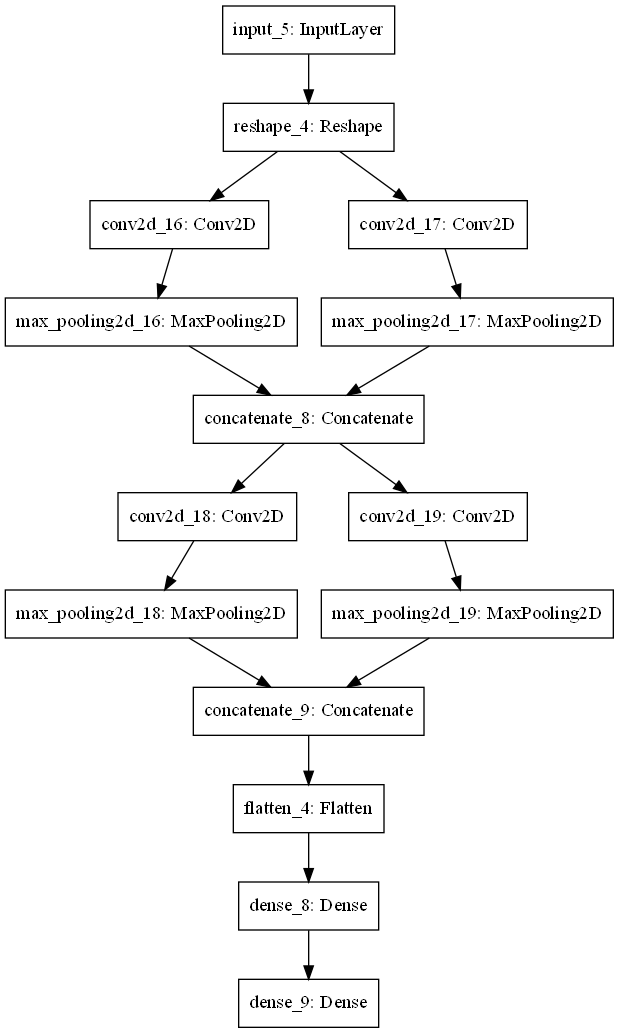

In [60]:
tf.keras.utils.plot_model(
    model, show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

In [61]:
# let's split the data and train our model
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_encoded, y_encoded, test_size=.2)

In [62]:
x_train[:3]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [65]:
# train our model
model.fit(x_train, y_train, epochs=35)

Epoch 1/35
1/1 [==============================] - 0s 17ms/step - loss: 1.5380 - acc: 0.3929
Epoch 2/35
1/1 [==============================] - 0s 15ms/step - loss: 1.3446 - acc: 0.5714
Epoch 3/35
1/1 [==============================] - 0s 15ms/step - loss: 1.1331 - acc: 0.7857
Epoch 4/35
1/1 [==============================] - 0s 15ms/step - loss: 0.9248 - acc: 0.8571
Epoch 5/35
1/1 [==============================] - 0s 14ms/step - loss: 0.7315 - acc: 0.8571
Epoch 6/35
1/1 [==============================] - 0s 14ms/step - loss: 0.5598 - acc: 0.9286
Epoch 7/35
1/1 [==============================] - 0s 14ms/step - loss: 0.4054 - acc: 0.9643
Epoch 8/35
1/1 [==============================] - 0s 15ms/step - loss: 0.2844 - acc: 1.0000
Epoch 9/35
1/1 [==============================] - 0s 15ms/step - loss: 0.1962 - acc: 1.0000
Epoch 10/35
1/1 [==============================] - 0s 15ms/step - loss: 0.1368 - acc: 0.9643
Epoch 11/35
1/1 [==============================] - 0s 15ms/step - loss: 0.1013 

In [66]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 11ms/step - loss: 10.1705 - acc: 0.2857


[10.170499801635742, 0.2857142984867096]

In [67]:
encoder.classes_[4]

'reserve_enq'

In [68]:
def predict_char_embd(text):
    text_v = np.zeros((1, longest_seq, unique_chars))
    for i, token in enumerate(text):
        if i>longest_seq:
            break
        text_v[0, i] = char2idx[token]
    # predict the input 
    prediction = model.predict(text_v)
    label = encoder.classes_[np.argmax(prediction)]
    return label

In [69]:
predict_char_embd("how mcuh for the french course ?")

'cost_enq'